### Fig. 1 | Phenotyping pain in the UK Biobank. ###
We run the analyses for four elements of the first figure.
1. Obtain the number of pain cases in the UK Biobank for each body sites.
2. Estimate the co-occurence between pain sites.
3. Vectorize the co-occurence and estimate the association with distance
4. Look at the prevalence of different pain sites across 25 non-cancer illnesses
5. Examine in the online data the association with number of pain sites.

In [21]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import nltools
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
plt.rcParams['font.size'] = 8
sns.set(font="Arial", style = 'white')


Folder = '/Users/Chris/Script_folder/' #Path to files

In [2]:
# Load files
preproc_UKB_Test, preproc_UKB_Train = pd.read_csv(Folder + '5_TestData_PreprocFeatures_Adv.csv'), pd.read_csv(Folder + '5_TrainData_PreprocFeatures_Adv.csv')
preproc_UKB_All = preproc_UKB_Train.append(preproc_UKB_Test).sort_values(by = 'eid').reset_index(drop = True)

In [3]:
#### FIGURE 1. Obtain frequency for discovery, validation #####
Count = ['Headaches','FacialPain','NeckShoulderPain','StomachAbdominalPain','BackPain','HipPain','KneePain', 'WidespreadPain']
for i in Count: print(i + ':', preproc_UKB_All[i + 'LastMonth_T0'].sum()) 
print('Pain-free:', preproc_UKB_All.NoPainLastMonth_T0.sum())
print('Total:', len(preproc_UKB_All))

Headaches: 99350
FacialPain: 9027
NeckShoulderPain: 113733
StomachAbdominalPain: 42293
BackPain: 126792
HipPain: 54683
KneePain: 105347
WidespreadPain: 8710
Pain-free: 196914
Total: 493211


In [4]:
# Remove subjects with Pain All Over to compute co-occurence
noPAO = preproc_UKB_All[preproc_UKB_All.WidespreadPainLastMonth_T0!=1]
# Sites for Acute and Chronic Pain
AP, CP = ['Acute' + i for i in Count], ['Chronic' + i for i in Count] # List comprehension to insert 'Chronic' or 'Acute string

In [5]:
# Deriving matrix of co-occurence for each pain types.
clf = LogisticRegression(penalty='none', solver = 'lbfgs') #Logistic Regression Model, lbfgs default

array_CP, array_AP = np.zeros((7,7)), np.zeros((7,7))
D, array_D = np.arange(0,7), np.zeros((7,7)) #Sites are ordered from the sites superior (headaches) to inferior (knee)
for idx in range(0, 7): # For loop
    for idx2 in range(0, 7):
        if idx != idx2:
            array_D[idx, idx2] = abs(D[idx] - D[idx2]) #Taking distance
            
            clf.fit(noPAO[[CP[idx] + '_T0']].values, noPAO[CP[idx2] + '_T0'].values)
            array_CP[idx, idx2] = clf.coef_[0][0] 
            
            clf.fit(noPAO[[AP[idx] + '_T0']].values, noPAO[AP[idx2] + '_T0'].values)
            array_AP[idx, idx2] = clf.coef_[0][0]

In [6]:
# Applying masks for matrices (visualization), name of Sites
tril_mask, triu_mask = np.zeros_like(array_CP, dtype=np.bool), np.zeros_like(array_AP, dtype=np.bool)
tril_mask[np.tril_indices_from(tril_mask)], triu_mask[np.triu_indices_from(triu_mask)] = True, True
Sites = ['Headaches','Facial','Neck/Shoulder','Stomach/Abdo','Back','Hip','Knee'] #Short version
Sites2 = ['H', 'F', 'N/S', 'S/A', 'B', 'H', 'K'] #Very short version


# OR matrices (exponential functions of betas)
OR_CP, OR_AP = pd.DataFrame(data = np.exp(array_CP), columns = Sites2, index = Sites), pd.DataFrame(data = np.exp(array_AP), columns = Sites2, index = Sites)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


([Text(0.5, 0, 'H'),
  Text(1.5, 0, 'F'),
  Text(2.5, 0, 'N/S'),
  Text(3.5, 0, 'S/A'),
  Text(4.5, 0, 'B'),
  Text(5.5, 0, 'H'),
  Text(6.5, 0, 'K')],
 [Text(0, 0.5, 'Headaches'),
  Text(0, 1.5, 'Facial'),
  Text(0, 2.5, 'Neck/Shoulder'),
  Text(0, 3.5, 'Stomach/Abdo'),
  Text(0, 4.5, 'Back'),
  Text(0, 5.5, 'Hip'),
  Text(0, 6.5, 'Knee')])

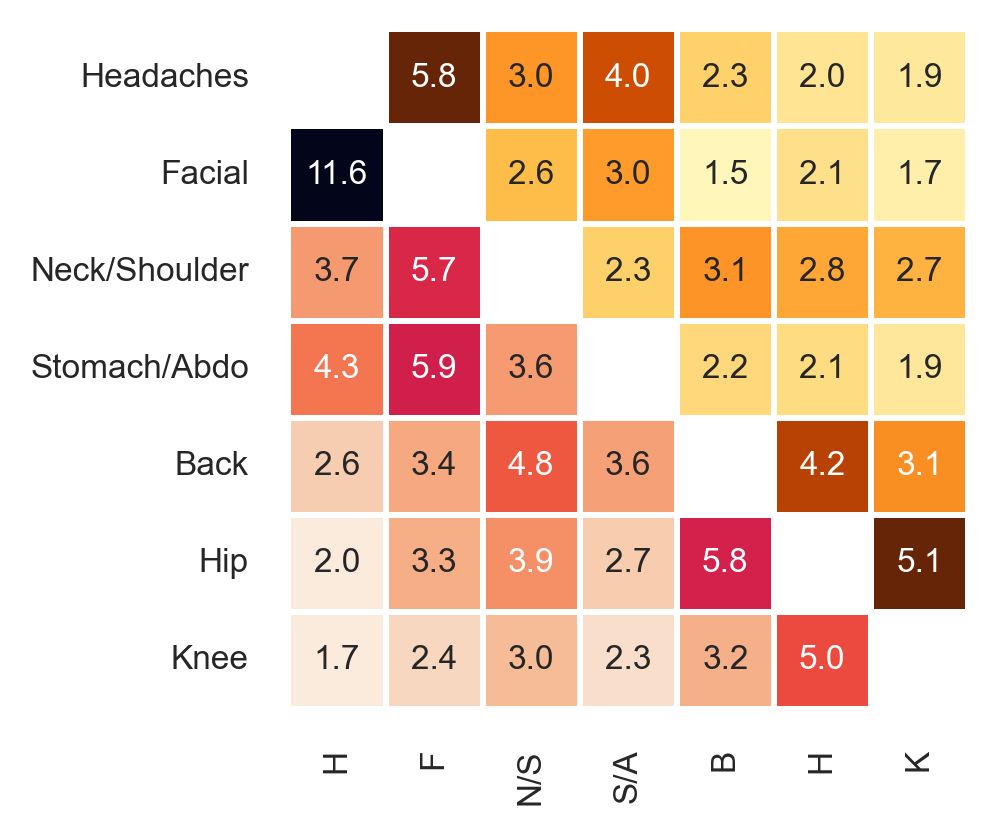

In [22]:
#### FIGURE 2A. Co-occurence matrix of Acute and Chronic Pain ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(4, 3))
sns.heatmap(ax = axs, data = OR_CP, mask = triu_mask, cmap = 'rocket_r', fmt=".1f", square = True, linewidths=1, annot = True, cbar = False, annot_kws={"fontsize": 8}, vmin = 2, vmax = 10)
sns.heatmap(ax = axs, data = OR_AP, mask = tril_mask, cmap = 'YlOrBr', fmt=".1f", square = True, linewidths=1, annot = True, cbar = False, annot_kws={"fontsize": 8}, vmin = 1, vmax = 5)
axs.set_xticklabels(axs.get_xmajorticklabels(), fontsize = 8, rotation = 90), axs.set_yticklabels(axs.get_ymajorticklabels(), fontsize = 8)

In [8]:
# Vectorize matrices excluding diagonals
vec_D, vec_CP, vec_AP = array_D[np.triu_indices(7, k = 1)], array_CP[np.triu_indices(7, k = 1)], array_AP[np.triu_indices(7, k = 1)]

# Permutate 10,000 null models of these associations
perm_CP = nltools.stats.correlation_permutation(vec_D, vec_CP, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0) 
perm_AP = nltools.stats.correlation_permutation(vec_D, vec_AP, method='permute', n_permute=10000, metric='pearson', tail=2, return_perms=False, random_state=0) 
print('Chronic,', 'R2:', perm_CP['correlation']**2, 'p:', perm_CP['p'])
print('Acute,', 'R2:', perm_AP['correlation']**2, 'p:', perm_AP['p'])

Chronic, R2: 0.5595040911127516 p: 9.999000099990002e-05
Acute, R2: 0.3353439313849923 p: 0.005699430056994301


(None, None, <matplotlib.legend.Legend at 0x7fd2780b73d0>)

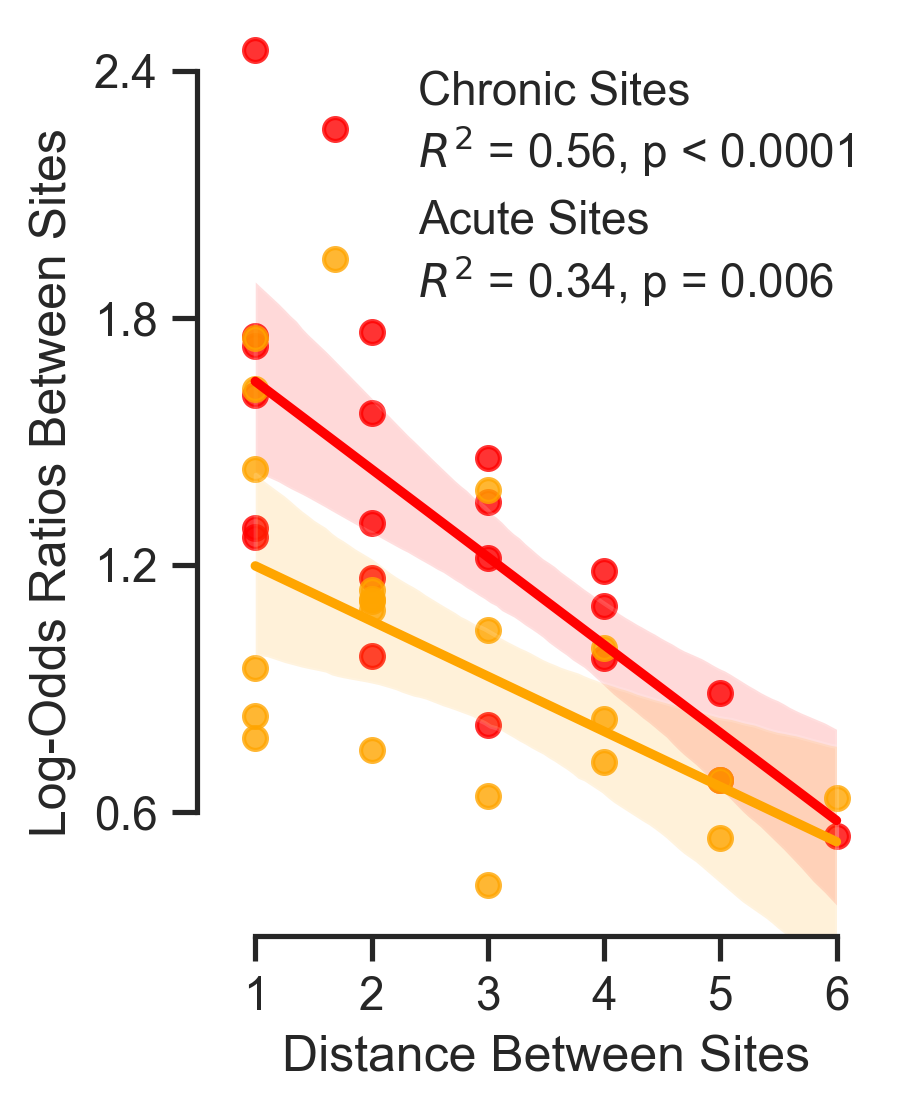

In [23]:
#### FIGURE 2B. Association between Distances and log-Odds Ratios ####
fig, axs = plt.subplots(ncols=1, nrows=1,  figsize=(3, 4))
sns.regplot(ax = axs, x = vec_D, y = vec_CP, color = 'red', scatter_kws={'s':30}, label = "Chronic Sites\n$R^2$ = 0.56, p < 0.0001") 
sns.regplot(ax = axs, x = vec_D, y = vec_AP, color = 'orange', scatter_kws={'s':30}, label = 'Acute Sites\n$R^2$ = 0.34, p = 0.006')
axs.set_xlim(0.5, 6.5), axs.set_ylim(0.3, 2.5)
axs.set_xticks(np.arange(1,7,1)), axs.set_yticks([0.6, 1.2, 1.8, 2.4])
axs.set_xticklabels(np.arange(1,7,1)), axs.set_yticklabels([0.6, 1.2, 1.8, 2.4])
axs.set_xlabel('Distance Between Sites'), axs.set_ylabel('Log-Odds Ratios Between Sites')
axs.spines['bottom'].set_bounds((1, 6)), axs.spines['left'].set_bounds((0.6, 2.4))
axs.tick_params(left=True, bottom=True), axs.spines[['top', 'right']].set_visible(False), axs.legend(frameon=False)

In [10]:
#### Obtain Non-Cancer Illnesses ####
NCI = pd.read_csv(Folder + '1_UKB_NonCancer_Illness.csv') #Script to obtain the file will be uploaded.
NCI = NCI.set_index('Unnamed: 0')
Coding_NCI = pd.read_csv(Folder + 'coding6.tsv', sep = '\t')
Coding_NCI = Coding_NCI[(Coding_NCI.coding!=-1) & (Coding_NCI.coding!=99999)]

In [11]:
# Filter columns, make sure that each diagnoses is present once, and add eids to merge the files
NCI_T0 = NCI[NCI.filter(like = '_T0').columns.tolist()]
NCI_T0 = pd.DataFrame(data = np.where(NCI_T0 > 0, 1, NCI_T0), columns = NCI_T0.columns)
NCI_T0['eid'] = NCI.eid
NCI_T0 = NCI_T0[NCI_T0.eid.isin(preproc_UKB_All.eid)].reset_index(drop = True)

In [12]:
# Create a file of Diagnoses
NCI_T0['NCI_Free_T0'] = np.where(NCI_T0.drop(columns = 'eid').sum(axis = 1) > 0, 0, 1) #Compute NCI-Free for those reporting no NCI.
Z1 = ['NCI_Free_T0', 'NCI_cervical spondylosis_T0', 'NCI_spine arthritis/spondylitis_T0','NCI_disc degeneration_T0', 'NCI_fibromyalgia_T0','NCI_spinal injury_T0', 'NCI_headaches (not migraine)_T0', 'NCI_irritable bowel syndrome_T0','NCI_osteoarthritis_T0', 'NCI_migraine_T0','NCI_rheumatoid arthritis_T0', 'NCI_emphysema/chronic bronchitis_T0', 'NCI_trapped nerve/compressed nerve_T0','NCI_chronic fatigue syndrome_T0','NCI_gastric/stomach ulcers_T0','NCI_hiatus hernia_T0','NCI_endometriosis_T0','NCI_chronic obstructive airways disease/copd_T0', 'NCI_angina_T0','NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0','NCI_carpal tunnel syndrome_T0', 'NCI_pulmonary embolism +/- dvt_T0', 'NCI_stroke_T0','NCI_heart attack/myocardial infarction_T0','NCI_diabetes_T0','NCI_multiple sclerosis_T0']
Z2 = ['Free','Cervical Spondylosis','Spinal Spondylitis','Disc Degeneration','Fibromyalgia','Spinal Injury','Non-Migraine Headaches','Irritable Bowel Synd.','Osteoarthritis','Migraine','Rheumatoid Arthritis','Chronic Bronchitis','Compressed Nerve','Chronic Fatigue Synd.','Gastric Ulcers','Hiatus Hernia','Endometriosis','Chronic Obstructive\nPulmonary Disease','Angina','Gastro-Oesophageal\nReflux','Carpal Tunnel Synd.','Pulmonary Embolism ','Stroke','Myocardial Infarction','Diabetes','Multiple Sclerosis']
rename = dict(zip(Z1, Z2))
P = [i + 'LastMonth_T0' for i in Count]
DF = NCI_T0[Z1].rename(columns = rename)

In [13]:
# Computing prevalence of pain sites across NCI
list_illness, list_proportion = [], [] 
for i in Z2:
    Filter = DF[i]==1
    list_illness.append(len(preproc_UKB_All[Filter]))
    list_proportion.append(round(preproc_UKB_All[Filter][P].mean()*100,1).tolist())


In [14]:
# Some organizing for visualization
DF2 = pd.DataFrame(np.asarray(list_proportion), columns = Count, index = Z2).T.append(pd.Series(list_illness, name = 'Sample', index = Z2))
Count2 = ['KneePain','BackPain','NeckShoulderPain','HipPain','Headaches','StomachAbdominalPain','FacialPain','WidespreadPain']
DF2 = (DF2.T[Count2 + ['Sample']]).T
C2 = ['Knee','Back','Neck/Shoulder','Hip','Headaches','Stomach/Abdo','Facial','Pain All Over']
DF2 = DF2.rename(index = dict(zip(Count2, C2)))

col_pal = sns.color_palette("tab10",8) #Color palette

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


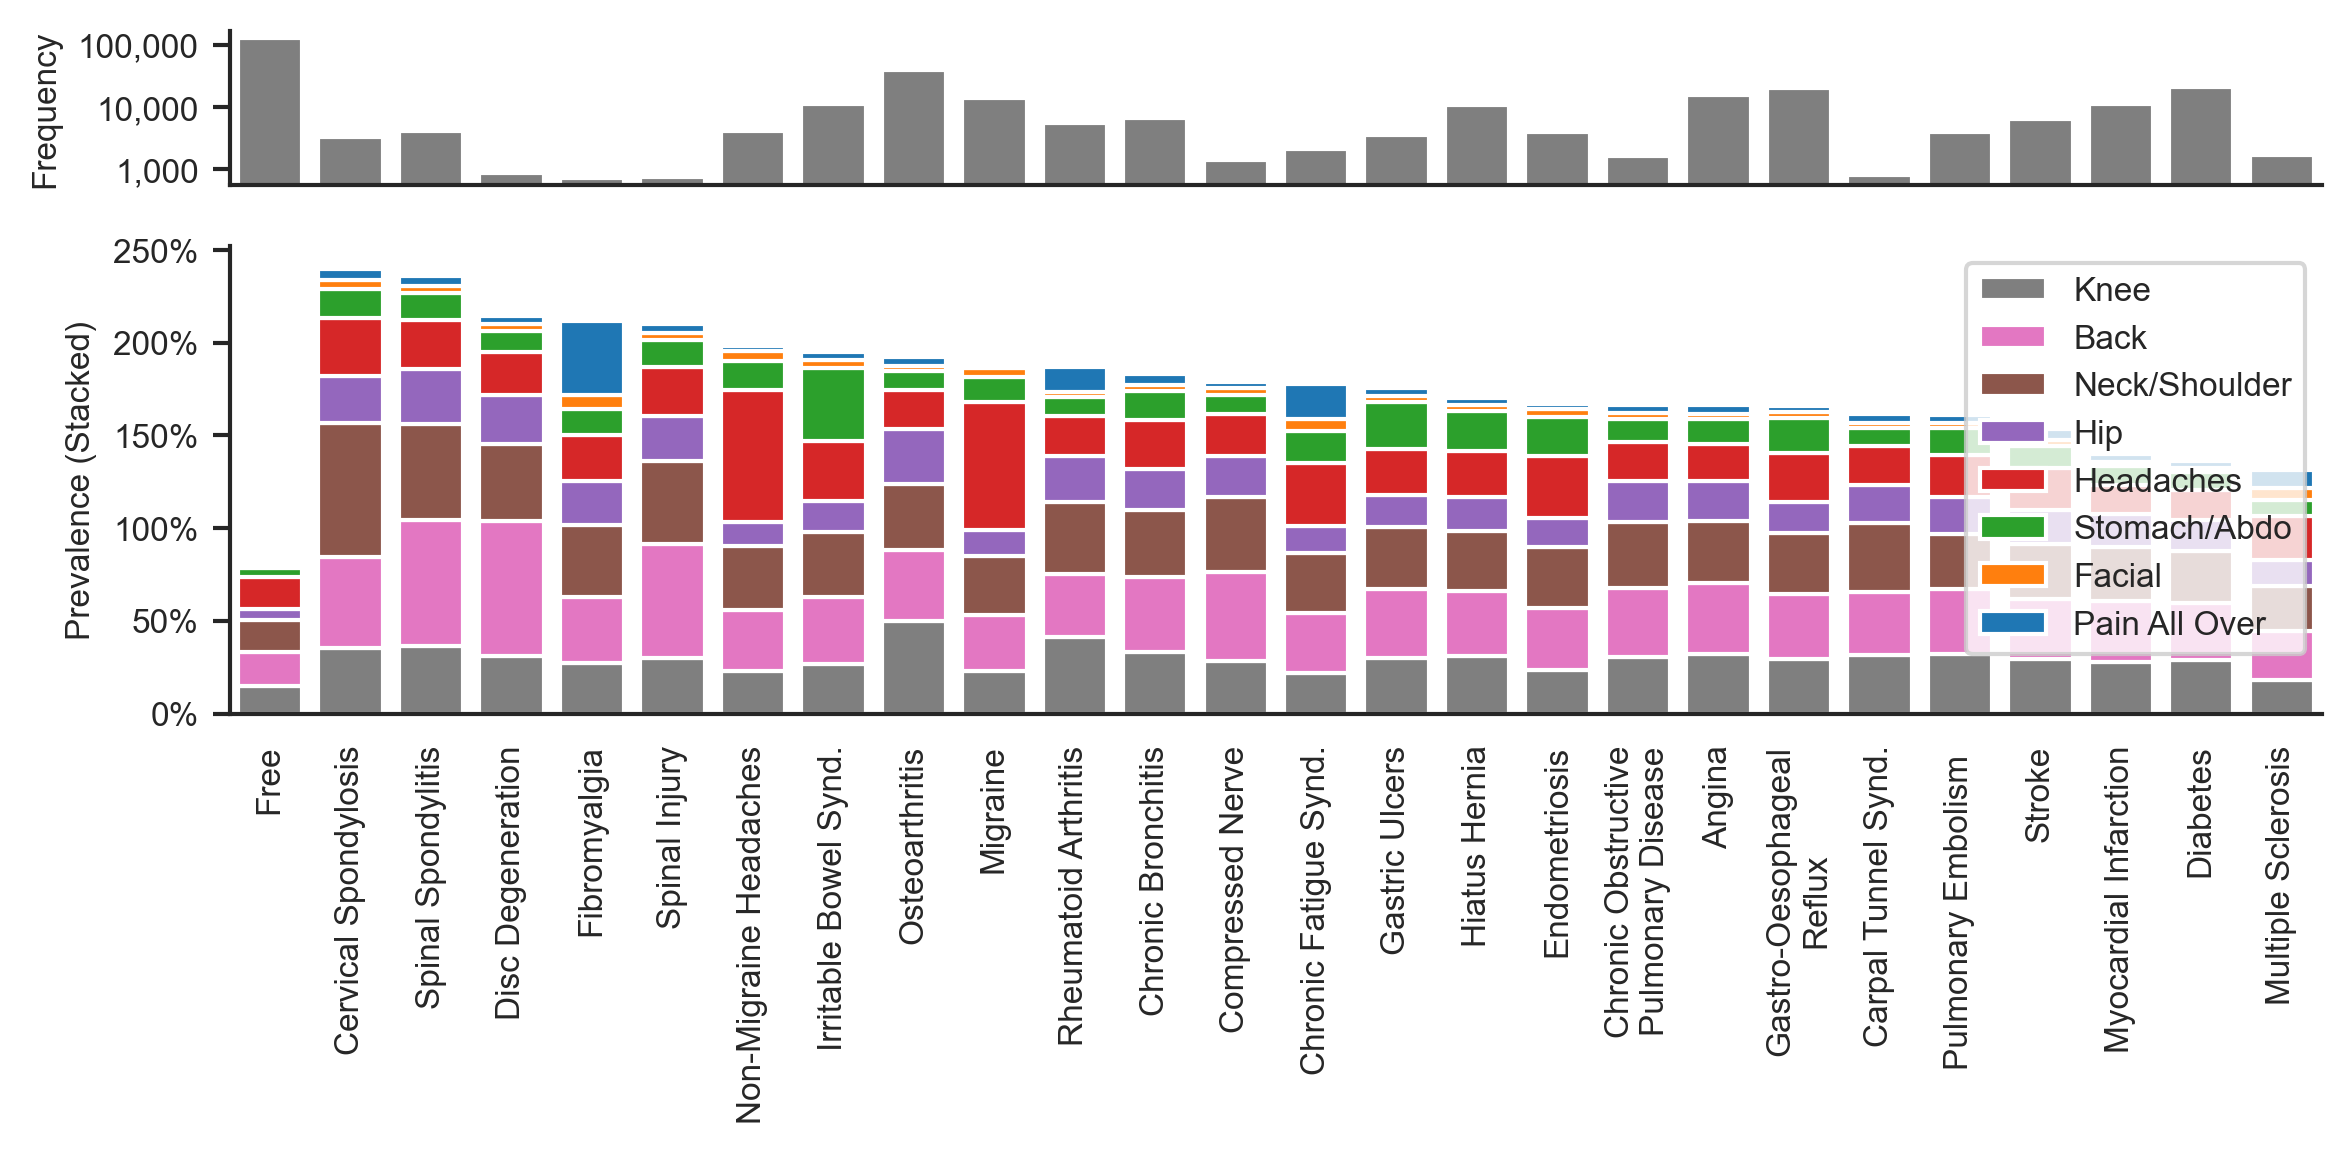

In [24]:
#### FIGURE 3. NCI and Stacked prevalences ####
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), gridspec_kw={'height_ratios': [0.33,1]})
#Fequency
axes[0].bar(x = Z2, height = DF2[Z2].loc['Sample'], color = col_pal[::-1][0])
axes[0].set_yscale('log'), axes[0].set_ylabel('Frequency', fontsize = 8), axes[0].set_xticklabels([])
axes[0].set_yticks([1000, 10000, 100000]), axes[0].set_yticklabels(['1,000', '10,000', '100,000'], fontsize = 8)
#Prevalence
for i in range(8): axes[1].bar(x = Z2, height = DF2.T[C2[i]], label = C2[i], color = col_pal[::-1][i], bottom = DF2.T[C2[0:i]].sum(axis = 1))
axes[1].set_ylabel('Prevalence (Stacked)', fontsize = 8), axes[1].set_yticks(np.arange(0,300,50))
axes[1].set_yticklabels(['0%', '50%', '100%', '150%', '200%', '250%'], fontsize = 8)
axes[1].legend(frameon=True, fontsize = 8, loc='upper right')
axes[1].set_xticklabels(Z2, rotation = 90, fontsize = 8, ha="center")
for i in range(2):
    axes[i].set_xlim((-0.5, 25.5))
    axes[i].spines[['top', 'right']].set_visible(False), axes[i].tick_params(left=True, length=4, width=1), axes[i].spines[['bottom', 'left']].set_linewidth(1)
fig.tight_layout()

In [16]:
# Online Data
Pain_Exp = pd.read_csv(Folder + 'experience_of_pain.csv')
columns = pd.read_csv(Folder + 'Columns_Pain_Experience_V1.csv')
dico = dict(zip(columns.OLD, columns.NEW))
Pain_Exp = Pain_Exp[columns.OLD].rename(columns = dico).replace({-121:np.nan, -818:np.nan, -99:np.nan})  #Remove the Prefer Not to Answer
Pain_Exp = Pain_Exp[Pain_Exp.ChronicPainDiscomfort==1] # Pick those with Chronic Pain only
Pain_Exp = Pain_Exp[Pain_Exp['WidespreadPainRating']==-100].reset_index(drop=True) ### Remove those with widespread pain

In [17]:
# Cleaning variables
Pain_Exp['Duration'] = Pain_Exp['Duration'].replace({-511.0: 0, -512.0:1, -513.0:2}) #Duration
for i in Pain_Exp.filter(like='F_').columns: Pain_Exp[i] = Pain_Exp[i].replace({-521.0: 0, -522.0:1, -523.0:2, -524.0:3}) # Widespread Symptoms
for i in Pain_Exp.filter(like='PHQ_').columns: Pain_Exp[i] = Pain_Exp[i].replace({-521.0: 0, -522.0:1, -523.0:2, -524.0:3}) # Widespread Symptoms
for i in Pain_Exp.filter(like='BPI_').columns: Pain_Exp[i] = Pain_Exp[i].replace({-521.0: 0, -522.0:1, -523.0:2, -524.0:3}) # Widespread Symptoms
Pain_Exp['Symptoms_Severity'] = Pain_Exp.filter(like = 'F_').sum(axis = 1, skipna=False)
Pain_Exp['PHQ_9'] = Pain_Exp.filter(like = 'PHQ_').sum(axis = 1, skipna=False)
Pain_Exp['BPI_7'] = Pain_Exp.filter(like = 'BPI_').sum(axis = 1, skipna=False)

In [18]:
# Pain Sites
Sites = pd.DataFrame(data=np.where(Pain_Exp.filter(like='Rating') ==-100,0,1), columns = [c[:-6] for c in Pain_Exp.filter(like='Rating').columns])
Pain_Exp['NumberPainSites'] = Sites[['HeadachesPain', 'FacialPain', 'NeckShoulderPain', 'BackPain', 'StomachAbdominalPain', 'HipPain', 'KneePain']].sum(axis = 1)

In [19]:
# Values per Number of Sites for visualization
Duration = [(Pain_Exp[Pain_Exp.NumberPainSites==k].Duration.value_counts() / Pain_Exp[Pain_Exp.NumberPainSites==k].Duration.count()).sort_index().values for k in range(8)]
Duration = np.asarray(Duration).T * 100
BPI = Pain_Exp.groupby('NumberPainSites').mean()[['BPI_RelationsWithOthers', 'BPI_Mood', 'BPI_WalkingAbility', 'BPI_Sleep', 'BPI_EnjoymentOfLife', 'BPI_NormalWork', 'BPI_GeneralActivity']].values.T
PHQ = Pain_Exp.groupby('NumberPainSites').PHQ_9.mean()
SS = Pain_Exp.groupby('NumberPainSites').mean()[['F_Cognitive', 'F_Fatigue', 'F_Waking']].values.T

# Material for visualization
correlations = round(Pain_Exp.corrwith(Pain_Exp.NumberPainSites)[['Duration', 'WorstPain', 'BPI_7', 'PHQ_9', 'Symptoms_Severity']], 2)
duration_label = ['5+ years', '1-5 years', '3-12 months']
bpi_label = ['Relationships', 'Mood', 'Walking Ability', 'Sleep', 'Enjoyment of Life', 'Normal Work', 'General Activity'][::-1]
ss_label = ['Cognitive\nSymptoms', 'Fatigue', 'Waking\nUnrefreshed'][::-1]
titles = ['Duration of\nPain or Discomfort', 'Rating of Worst\nPain Last 24 Hours', 'Impact of\nPain (BPI)', 'Depressive\nSymptoms (PHQ-9)', 'Symptoms\nSeverity Past Week']

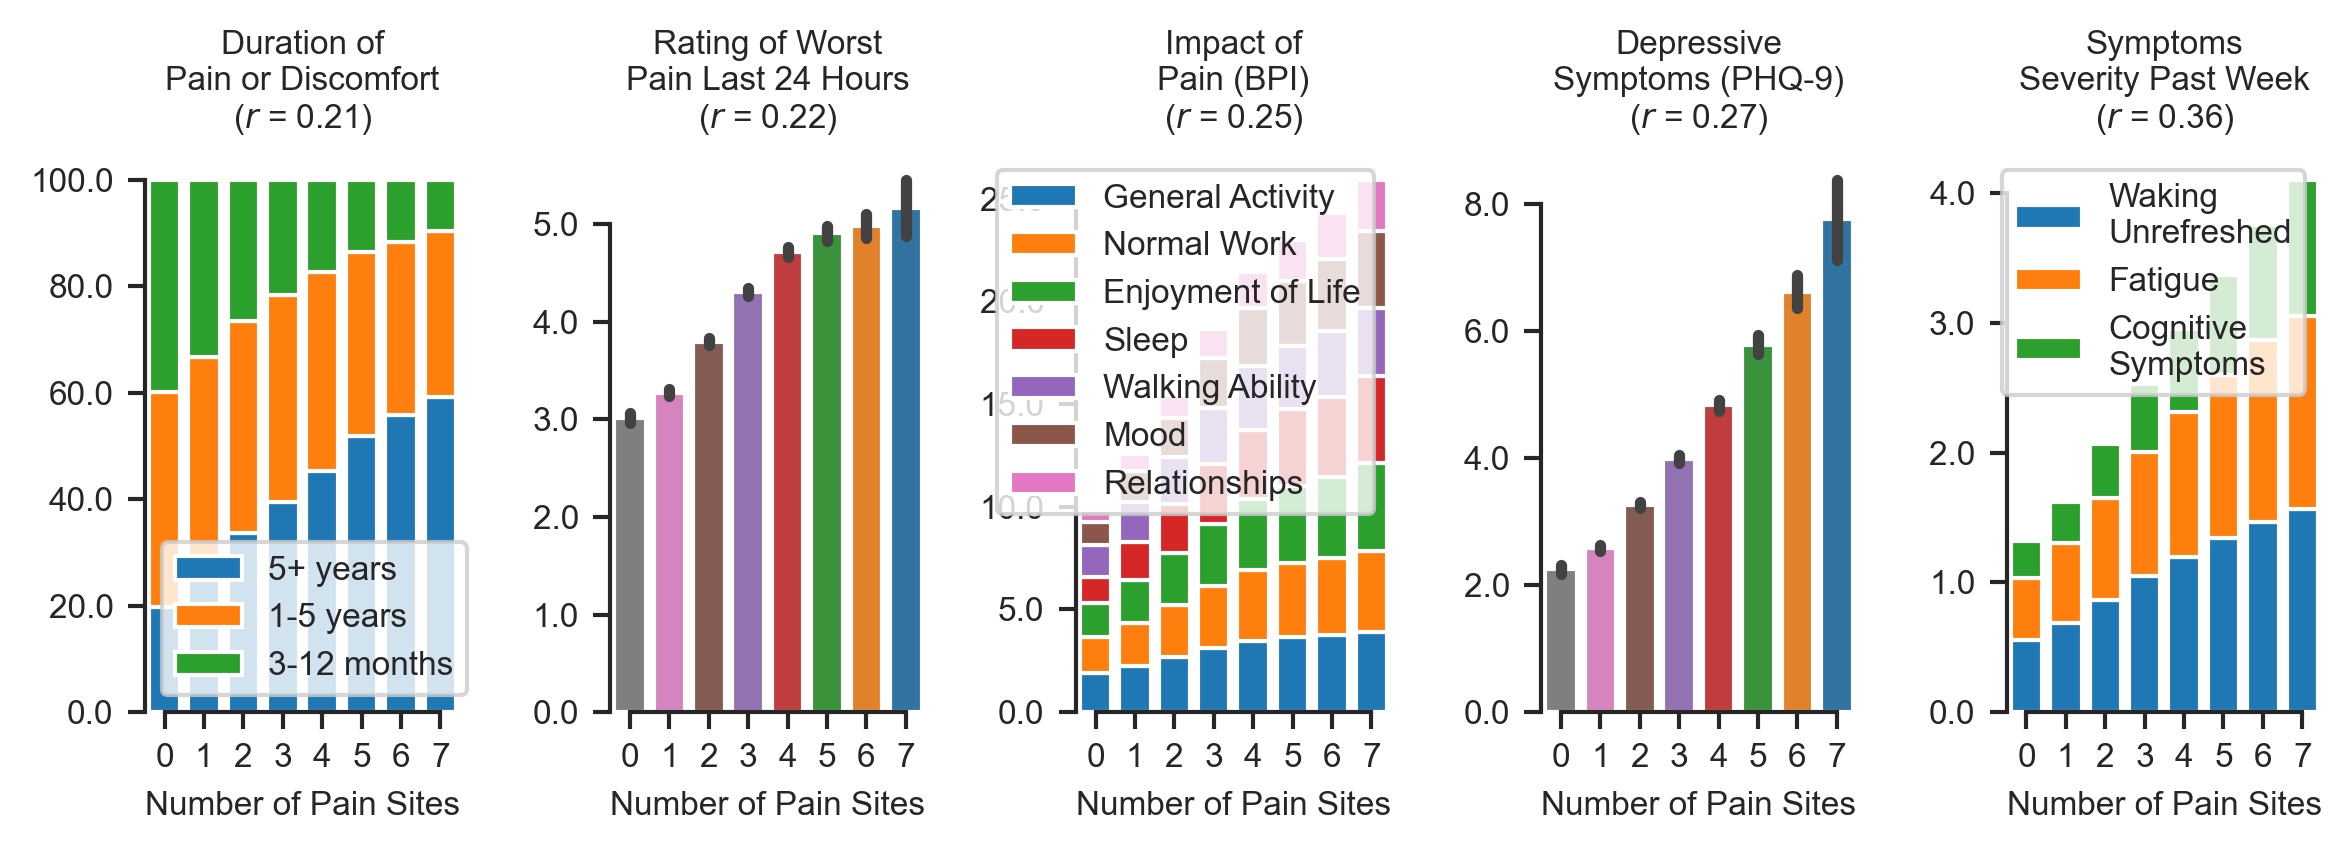

In [25]:
#### FIGURE 4. Online Data Association with Number of Pain Sites
fig, axs = plt.subplots(ncols=5, nrows=1,  figsize=(8, 3))
for i in range(3): axs[0].bar(np.arange(8), Duration[::-1][i], label = duration_label[i], color = col_pal[i], bottom = Duration[::-1][0:i].sum(axis = 0))
sns.barplot(ax = axs[1], data = Pain_Exp, x = 'NumberPainSites', y = 'WorstPain', palette = col_pal[::-1])
for i in range(7): axs[2].bar(np.arange(8), BPI[::-1][i], label = bpi_label[i], color = col_pal[i], bottom = BPI[::-1][0:i].sum(axis = 0))
sns.barplot(ax = axs[3], data = Pain_Exp, x = 'NumberPainSites', y = 'PHQ_9', palette = col_pal[::-1])
for i in range(3): axs[4].bar(np.arange(8), SS[::-1][i], label = ss_label[i], color = col_pal[i], bottom = SS[::-1][0:i].sum(axis = 0))
axs[0].legend(frameon=True, fontsize = 8), axs[2].legend(frameon=True, fontsize = 8), axs[4].legend(frameon=True, fontsize = 8)
for col in range(5): 
    axs[col].set_xlim(-0.5, 7.5), axs[col].set_xticks(np.arange(8)), axs[col].set_xticklabels(np.arange(8), fontsize = 8)
    axs[col].spines['bottom'].set_bounds((0, 7))
    axs[col].set_ylabel(''), axs[col].set_xlabel('Number of Pain Sites', fontsize = 8)
    axs[col].tick_params(left=True, bottom=True, length=4, width=1), axs[col].spines[['top', 'right']].set_visible(False), axs[col].spines[['bottom', 'left']].set_linewidth(1)
    axs[col].set_title(titles[col] + '\n($r$ = ' + str(correlations[col]) + ')', fontsize = 8)
    yticks = axs[col].get_yticks()
    axs[col].set_yticks(yticks[:-1])
    axs[col].spines['left'].set_bounds((yticks[0], yticks[-2])), axs[col].set_yticklabels(yticks[:-1], fontsize = 8)
fig.tight_layout()